# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.694793,True,6.666812
1,1.939838,True,4.904249
2,1.496117,True,6.084713
3,1.433540,True,4.617045
4,0.480489,True,3.836808
...,...,...,...
995,1.014702,True,6.211560
996,-0.354563,True,6.226556
997,1.081872,True,6.648233
998,0.556500,True,4.178191


<AxesSubplot: xlabel='v0'>

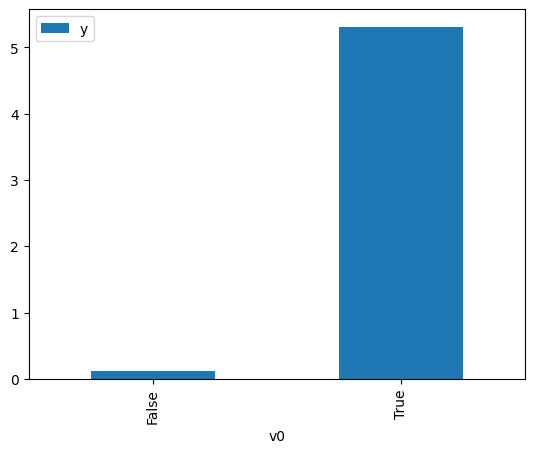

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

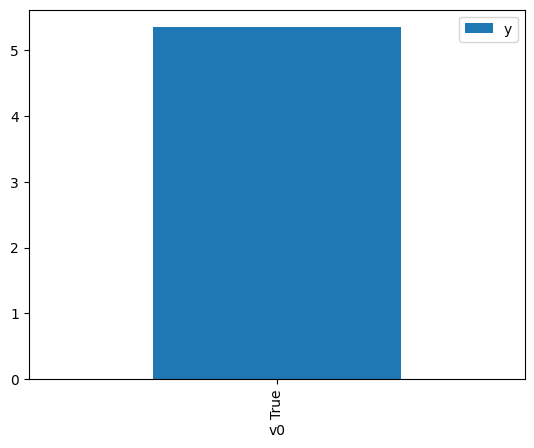

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.994771,False,-0.299659,0.173389,5.767384
1,1.402116,False,0.453620,0.098719,10.129809
2,1.670344,False,-1.650445,0.066646,15.004652
3,0.456844,False,0.160065,0.330979,3.021341
4,0.664541,False,0.941111,0.262105,3.815261
...,...,...,...,...,...
995,1.609900,False,-1.224715,0.072900,13.717466
996,1.667901,False,-1.899619,0.066889,14.950185
997,0.664541,False,0.941111,0.262105,3.815261
998,1.063984,False,-0.686202,0.158131,6.323857


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.235132,True,6.388387,0.874922,1.142960
1,1.099936,True,6.434019,0.849354,1.177365
2,1.213970,True,7.829581,0.871180,1.147868
3,1.672637,True,5.252571,0.933581,1.071144
4,-0.056355,True,4.283871,0.471324,2.121685
...,...,...,...,...,...
995,1.467878,True,5.864889,0.910229,1.098624
996,0.514733,True,6.677389,0.689139,1.451085
997,1.527983,True,7.113033,0.917761,1.089608
998,0.874906,True,6.008448,0.797478,1.253954


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                          1.045e+04
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:40:52   Log-Likelihood:                         -1406.7
No. Observations:                1000   AIC:                                      2817.
Df Residuals:                     998   BIC:                                      2827.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3381      0.036      9.325      0.000       0.267       0.409
x2             5.0857      0.054     93.451      0.000       4.979       5.193
==============================================================================
Omnibus:                        1.285   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                1.169
Skew:                          -0.034   Prob(JB):                        0.557
Kurtosis:                       3.153   Cond. No.                         2.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""